In [1]:
# Dependencies
import tweepy
import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import json
from config import consumer_key, consumer_secret, access_token, access_token_secret

In [2]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
# Twitter API Keys
consumer_key = consumer_key
consumer_secret = consumer_secret
access_token = access_token
access_token_secret = access_token_secret


#consumer_key = "EsL9VcKMyoyq8XuJsT1okbqul"
#consumer_secret = "yVYSDs5L2u8ryU3RcuhpyGOyoaupsTNL0rVrD4SIZ3mJobiRuZ"
#access_token = "71095164-Wa9xHM2rB9X6s98LSshkROImlFTTlXKC4zwv3R9t7"
#access_token_secret = "ThbyID6RaBk4gOtEfqBdPqWPz9g9ghi1dEv4x5dG7mH60"




In [4]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [5]:
#Target users on twitter
user_target = ["BBC","CBS","CNN","FoxNews","nytimes"]
numberOfTweetsRequired = 100
sourceTweetsDict = {}


In [6]:
#This cell will take some time to run
for user in user_target:
    counter = 0
    sourceTweetsDict[user] = [] 
    for x in range(1, 6): # 20 * x = total tweets 

        # Get all tweets from home feed
         public_tweets = api.user_timeline(user, page=x) 

         for tweet in public_tweets:
            sourceTweetsDict[user].append(tweet["text"])
#print(sourceTweetsDict)
   

In [7]:
#verify all data was retrieve
numberOfTweetsRequired = 100
for key in sourceTweetsDict.keys():
    if(len (sourceTweetsDict[key]) != numberOfTweetsRequired):
        print("Failure: not enough tweets from --> " + str(key))

     

In [8]:
def getAvg(tweet = ""):
    sentimentCount = 0
    sentimentOut = []     #to store a list of sentime value per tweet
    zen = TextBlob(tweet)
    for sentence in zen.sentences:
                 sentimentOut.append(sentence.sentiment.polarity)
                 #print(sentence.sentiment.polarity)
                 sentimentCount = sentimentCount + 1
    return(np.mean(sentimentOut))
    

In [9]:
everySentiment = {}
everySentiment["Media Type"] = []
everySentiment["Tweetx"] = []
everySentiment["Polarity"] = []

for key in sourceTweetsDict.keys():
    for x in range(numberOfTweetsRequired):
        everySentiment["Media Type"].append(key)
        everySentiment["Tweetx"].append(x)
        tweet = sourceTweetsDict[key][x]            
        everySentiment["Polarity"].append( getAvg(tweet)) 
        
        
#print(len (everySentiment["Polarity"]))

In [10]:
#translate tweet to senitment -1 to 1
sourceSentiment = {}

for key in sourceTweetsDict.keys():
    sourceSentiment[key] = [] 
    for tweet in sourceTweetsDict[key]:
         zen = TextBlob(tweet)
         sentimentCount = 0
         sentimentOut = []     #to store a list of sentime value per tweet
         for sentence in zen.sentences:
             sentimentOut.append(sentence.sentiment.polarity)
             #print(sentence.sentiment.polarity)
             sentimentCount = sentimentCount + 1
         sourceSentiment[key].append( sum(sentimentOut)/sentimentCount) 
         #print("Avg: " + str( sum(sentimentOut)/sentimentCount))
       

In [11]:
#Vader Analysis
vader_results_list = []
for key in sourceTweetsDict.keys():

    # Variables for holding sentiments
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []

    # Loop through all tweets
    for tweetText in sourceTweetsDict[key]:

        # Run Vader Analysis on each tweet
        results = analyzer.polarity_scores(tweetText)
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]

        # Add each value to the appropriate list
        compound_list.append(compound)
        positive_list.append(pos)
        negative_list.append(neg)
        neutral_list.append(neu)

    # Create a dictionaty of results
    user_results = {
        "Username": key,
        "Compound Score": np.mean(compound_list),
        "Postive Score":  np.mean(positive_list),
        "Neutral Score":  np.mean(neutral_list),
        "Negative Score": np.mean(negative_list)
      }

    # Append dictionary to list
    vader_results_list.append(user_results)

    # Print the Averages
    print(f"User: {key}")
    print(f"  Compound: {np.mean(compound_list):.3f}")
    print(f"  Positive: {np.mean(positive_list):.3f}")
    print(f"  Neutral:  {np.mean(neutral_list):.3f}")
    print(f"  Negative: {np.mean(negative_list):.3f}")

User: BBC
  Compound: 0.092
  Positive: 0.091
  Neutral:  0.861
  Negative: 0.048
User: CBS
  Compound: 0.370
  Positive: 0.152
  Neutral:  0.829
  Negative: 0.019
User: CNN
  Compound: -0.062
  Positive: 0.066
  Neutral:  0.832
  Negative: 0.102
User: FoxNews
  Compound: -0.042
  Positive: 0.074
  Neutral:  0.830
  Negative: 0.096
User: nytimes
  Compound: 0.034
  Positive: 0.094
  Neutral:  0.823
  Negative: 0.082


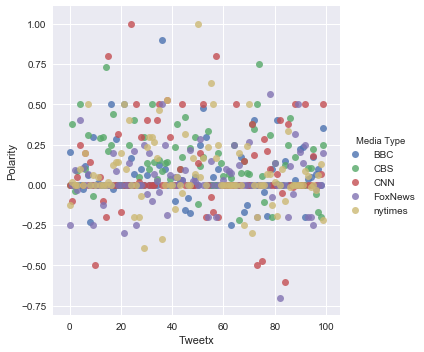

In [17]:
#plot TextBlob data scatter plot
%matplotlib inline
sentiment_df = pd.DataFrame.from_dict(everySentiment)


sns.lmplot(data=sentiment_df, x='Tweetx', y="Polarity", hue="Media Type",fit_reg=False)
plt.show()